# 종합 통계 실습

## 비즈니스 시나리오

> 여러분은 식품·와인 유통 기업 **FreshCart**의 데이터 분석팀 인턴입니다. \
> 마케팅팀이 6차례 캠페인을 진행했지만 수락률이 낮아 경영진이 우려하고 있습니다. \
> 고객 데이터를 분석하여 **다음 캠페인의 집중 공략 전략**을 수립해 주세요.

---

| Part | 주제 | 핵심 질문 |
|------|------|-----------|
| **Part 0** | 데이터 전처리 | (코드 제공) |
| **Part 1** | 탐색적 데이터 분석 | 고객은 누구인가? |
| **Part 2** | 확률분포 모델링 | 고객 행동은 어떤 패턴을 따르는가? |
| **Part 3** | 추정과 가설검정 | 고소득 고객과 저소득 고객의 소비는 다른가? |
| **Part 4** | 고급 검정 | 교육, 결혼, 캠페인 반응의 관계는? |
| **Part 5** | 상관분석 / 비율 비교 | 변수 간 관계를 파악하고, 캠페인 효과를 검증할 수 있는가? |
| **Challenge** | 종합 분석 보고서 | 다음 캠페인 타겟은 누구인가? |

### 데이터 셋 개요

| 항목 | 내용 |
|------|------|
| **출처** | Kaggle |
| **URL** | https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis |
| **크기** | 약 2,240행 × 29열 |
| **파일명** | `marketing_campaign.csv` |
| **도메인** | 식품·와인 유통 기업 |

**설명:** 고객 성격 분석은 기업의 이상적인 고객을 심층 분석하는 방법론이다. 고객 세그먼트별 니즈·행동·관심사를 파악해 제품 및 마케팅을 최적화하는 데 활용한다.

---

### 변수 목록

#### 고객 정보

| # | 변수명 | 설명 |
|---|--------|------|
| 1 | `ID` | 고객 고유 식별자 |
| 2 | `Year_Birth` | 고객 출생연도 |
| 3 | `Education` | 최종 학력 |
| 4 | `Marital_Status` | 결혼 상태 |
| 5 | `Income` | 연간 가구 소득 |
| 6 | `Kidhome` | 가구 내 어린 자녀 수 |
| 7 | `Teenhome` | 가구 내 십대 자녀 수 |
| 8 | `Dt_Customer` | 고객 등록일 |
| 9 | `Recency` | 마지막 구매 이후 경과 일수 |

---

#### 소비 패턴 — 최근 2년간 지출 금액

| # | 변수명 | 설명 |
|---|--------|------|
| 10 | `MntWines` | 와인 지출 금액 |
| 11 | `MntFruits` | 과일 지출 금액 |
| 12 | `MntMeatProducts` | 육류 지출 금액 |
| 13 | `MntFishProducts` | 생선 지출 금액 |
| 14 | `MntSweetProducts` | 과자·디저트 지출 금액 |
| 15 | `MntGoldProds` | 골드 지출 금액 |

---

#### 캠페인 반응

| # | 변수명 | 설명 |
|---|--------|------|
| 16 | `NumDealsPurchases` | 할인 적용 구매 횟수 |
| 17 | `NumWebPurchases` | 웹사이트를 통한 구매 횟수 |
| 18 | `NumCatalogPurchases` | 카탈로그를 통한 구매 횟수 |
| 19 | `NumStorePurchases` | 오프라인 매장 구매 횟수 |
| 20 | `NumWebVisitsMonth` | 최근 한 달간 웹사이트 방문 횟수 |
| 21 | `AcceptedCmp3` | 3차 캠페인 제안 수락 여부 (1=수락, 0=거절) |
| 22 | `AcceptedCmp4` | 4차 캠페인 제안 수락 여부 |
| 23 | `AcceptedCmp5` | 5차 캠페인 제안 수락 여부 |
| 24 | `AcceptedCmp1` | 1차 캠페인 제안 수락 여부 |
| 25 | `AcceptedCmp2` | 2차 캠페인 제안 수락 여부 |
| 26 | `Complain` | 최근 2년 내 불만 제기 여부 (1=있음, 0=없음) |
| 27 | `Z_CostContact` | 상수값 3 — 캠페인 1회당 연락 비용 |
| 28 | `Z_Revenue` | 상수값 11 — 캠페인 성공 시 수익 |
| 29 | `Response` | 최종 캠페인 제안 수락 여부 **(타깃 변수)** |

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import trim_mean
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.proportion import (
    proportions_ztest, proportion_confint, proportion_effectsize
)
from statsmodels.stats.power import NormalIndPower, TTestIndPower
import pingouin as pg
import warnings
import platform

warnings.filterwarnings('ignore')

if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

COLORS = {
    'blue': '#3B82F6', 'indigo': '#6366F1', 'violet': '#8B5CF6',
    'teal': '#14B8A6', 'emerald': '#10B981', 'amber': '#F59E0B',
    'rose': '#F43F5E', 'red': '#EF4444', 'slate': '#64748B',
    'sky': '#0EA5E9', 'purple': '#A855F7', 'lime': '#84CC16',
}

---
## Part 0: 데이터 전처리 (코드 제공)

아래 코드를 실행하여 분석에 사용할 데이터프레임 `df`를 준비합니다.
모든 파생변수가 생성되고 이상치가 제거된 상태에서 Part 1부터 분석을 시작합니다.

### 0-1. 데이터 로드 및 결측치 처리

In [2]:
df = pd.read_csv('data/marketing_campaign.csv', sep='\t')
print(f"원본 데이터: {df.shape[0]}행 × {df.shape[1]}열")
print(f"Income 결측치: {df['Income'].isnull().sum()}개")

df['Income'] = df['Income'].fillna(df['Income'].median())
print(f"→ Income 중앙값({df['Income'].median():,.0f})으로 대치 완료")

원본 데이터: 2240행 × 29열
Income 결측치: 24개
→ Income 중앙값(51,382)으로 대치 완료


### 0-2. 파생변수 생성

In [3]:
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts',
                 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
purchase_cols = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
campaign_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
                 'AcceptedCmp4', 'AcceptedCmp5', 'Response']

df['Age'] = 2024 - df['Year_Birth']
df['Total_Spending'] = df[spending_cols].sum(axis=1)
df['Total_Purchases'] = df[purchase_cols].sum(axis=1)
df['Total_Accepted'] = df[campaign_cols].sum(axis=1)
df['Has_Children'] = (df['Kidhome'] + df['Teenhome']) > 0
df['Income_Group'] = pd.qcut(df['Income'], 3, labels=['Low', 'Mid', 'High'])

bins = [0, 39, 49, 59, 200]
labels_age = ['30대 이하', '40대', '50대', '60대 이상']
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels_age)

edu_map = {'Basic': 'Undergraduate', '2n Cycle': 'Undergraduate',
           'Graduation': 'Graduate', 'Master': 'Postgraduate', 'PhD': 'Postgraduate'}
df['Education_Group'] = df['Education'].map(edu_map)

marital_map = {'Married': 'Together', 'Together': 'Together',
               'Single': 'Single', 'Divorced': 'Single', 'Widow': 'Single',
               'Alone': 'Single', 'Absurd': 'Single', 'YOLO': 'Single'}
df['Marital_Group'] = df['Marital_Status'].map(marital_map)

df['Campaign_Response'] = df['Total_Accepted'] > 0

df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
reference_date = df['Dt_Customer'].max()
df['Customer_Days'] = (reference_date - df['Dt_Customer']).dt.days

print("파생변수 생성 완료:")
for col in ['Age', 'Total_Spending', 'Total_Purchases', 'Total_Accepted',
            'Has_Children', 'Income_Group', 'Age_Group', 'Education_Group',
            'Marital_Group', 'Campaign_Response', 'Customer_Days']:
    print(f"  - {col}: {df[col].dtype}")

파생변수 생성 완료:
  - Age: int64
  - Total_Spending: int64
  - Total_Purchases: int64
  - Total_Accepted: int64
  - Has_Children: bool
  - Income_Group: category
  - Age_Group: category
  - Education_Group: str
  - Marital_Group: str
  - Campaign_Response: bool
  - Customer_Days: int64


### 0-3. 이상치 제거

In [4]:
n_before = len(df)
df = df[(df['Age'] <= 100) & (df['Income'] <= 200000)].copy()
n_after = len(df)
print(f"이상치 제거: {n_before}행 → {n_after}행 ({n_before - n_after}행 제거)")
print(f"\n최종 데이터 요약:")
print(f"  Age 범위: {df['Age'].min()} ~ {df['Age'].max()}")
print(f"  Income 범위: {df['Income'].min():,.0f} ~ {df['Income'].max():,.0f}")
print(f"\n데이터 준비가 완료되었습니다. Part 1부터 분석을 시작하세요!")

이상치 제거: 2240행 → 2236행 (4행 제거)

최종 데이터 요약:
  Age 범위: 28 ~ 84
  Income 범위: 1,730 ~ 162,397

데이터 준비가 완료되었습니다. Part 1부터 분석을 시작하세요!


---
## Part 1: 탐색적 데이터 분석 — "고객은 누구인가?"

기술통계량과 시각화를 통해 FreshCart 고객의 특성을 파악합니다.

### 문제 1-1. 중심경향과 산포도

`Income`, `Total_Spending`, `Age` 세 변수에 대해 다음을 계산하세요.

| 중심경향 | 산포도 |
|----------|--------|
| 평균(mean) | 분산(variance) |
| 중앙값(median) | 표준편차(std) |
| 최빈값(mode) | 사분위범위(IQR) |
| 5% 절사평균(trimmed mean) | 변동계수(CV) |

In [5]:
# TODO 1-1(a): Income, Total_Spending, Age의 중심경향 — 평균, 중앙값, 최빈값, 5% 절사평균
col_list = ['Income', 'Total_Spending', 'Age']
def central_tendency(data, col):
    col_mean = data[col].mean()
    col_median = data[col].median()
    col_mode = data[col].mode()[0] # 깔끔한 값을 얻기위해 index 사용
    col_trim = stats.trim_mean(data[col], 0.05)
    
    final = pd.DataFrame({ # 데이터 프레임 생성
        '값' : [col_mean, col_median, col_mode, col_trim] # 값 컬럼에 통계량 모두 넣기 
    }, index= ['평균', '중앙값', '최빈값', '절사평균']) # 인덱스 지정
    return display(final)

for col in col_list: # 한 번에 여러 테이블 출력하기 위한 코드
    print(f'{col}의 중심경향')
    central_tendency(df, col)


Income의 중심경향


,값
평균,51952.614043
중앙값,51381.500000
최빈값,51381.500000
절사평균,51740.153426


Total_Spending의 중심경향


,값
평균,605.986583
중앙값,396.500000
최빈값,46.000000
절사평균,561.119662


Age의 중심경향


,값
평균,55.101968
중앙값,54.000000
최빈값,48.000000
절사평균,55.074975


In [6]:
# TODO 1-1(b): Income, Total_Spending, Age의 산포도 — 분산(ddof=1), 표준편차, IQR, CV(%)
col_list = ['Income', 'Total_Spending', 'Age']
def dispersion(col):
    col_var = np.var(col, ddof=1)
    col_std = np.std(col, ddof=1)
    col_iqr = col.quantile(0.75) - col.quantile(0.25) # quantile은 내부에서 자동으로 정렬해준다고 함 !
    col_mean = col.mean() # CV를 계산하기 위해 평균값 계산
    col_cv = col_std / col_mean * 100
    final = pd.DataFrame({
        '값' : [col_var, col_std, col_iqr, col_cv]
    }, index= ['분산', '표준편차', '사분위 범위', '변동 계수(%)'])
    return display(final)

for col in col_list:
    print(f'{col}의 산포도')
    dispersion(df[col])

Income의 산포도


,값
분산,4.584509e+08
표준편차,2.141147e+04
사분위 범위,3.277325e+04
변동 계수(%),4.121345e+01


Total_Spending의 산포도


,값
분산,362241.666039
표준편차,601.865156
사분위 범위,976.500000
변동 계수(%),99.319881


Age의 산포도


,값
분산,136.966779
표준편차,11.703281
사분위 범위,18.000000
변동 계수(%),21.239315


### 문제 1-2. 분포 시각화

- **(a)** Income 히스토그램 + KDE + 평균/중앙값 수직선
- **(b)** Total_Spending 수평 박스플롯 + IQR 기준 이상치 개수 출력
- **(c)** Income_Group별 Total_Spending 바이올린 플롯

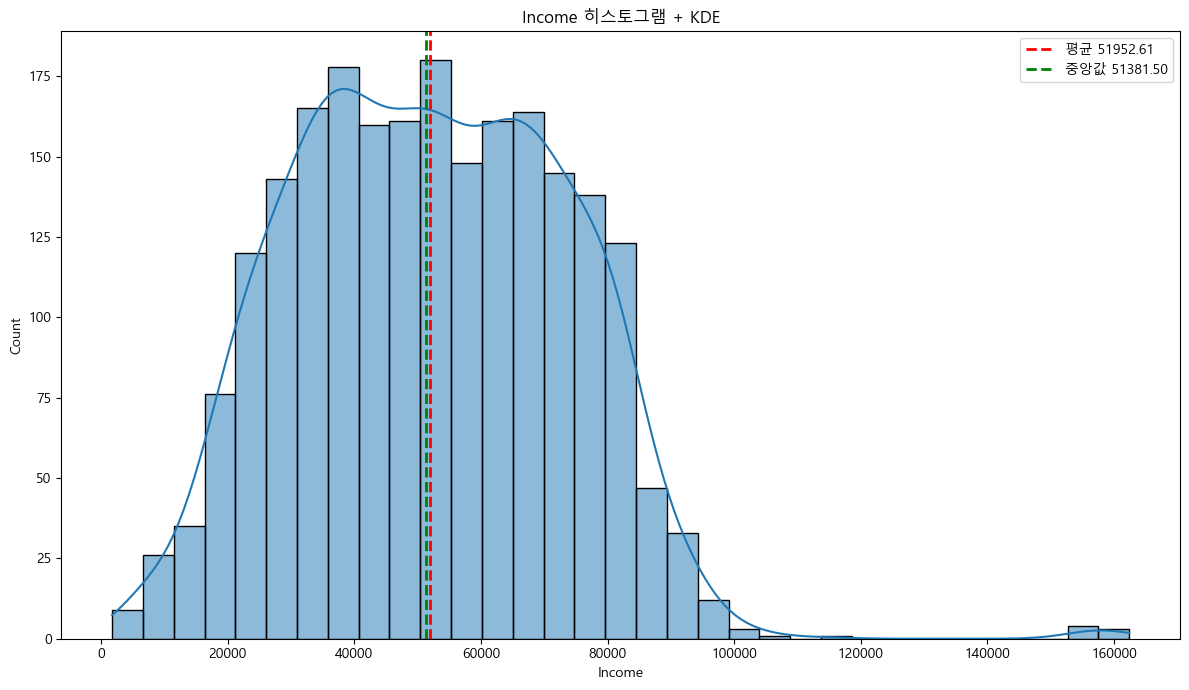

In [6]:
# TODO 1-2(a): Income 히스토그램 + KDE
fig, ax = plt.subplots(1,1, figsize=(12,7)) # 안까먹을려고 써봄
sns.histplot(df['Income'], bins='auto', kde='True') # income 컬럼의 값을 x축으로 사용, 막대 수 자동 지정, kde 사용
mean = df['Income'].mean()
median = df['Income'].median()
plt.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'평균 {mean:.2f}') # 평균 수직선 사용
plt.axvline(median, color='green', linestyle='--', linewidth=2, label=f'중앙값 {median:.2f}') # 중앙값 수직선 사용
plt.title('Income 히스토그램 + KDE')
plt.legend()
plt.tight_layout()
plt.show()

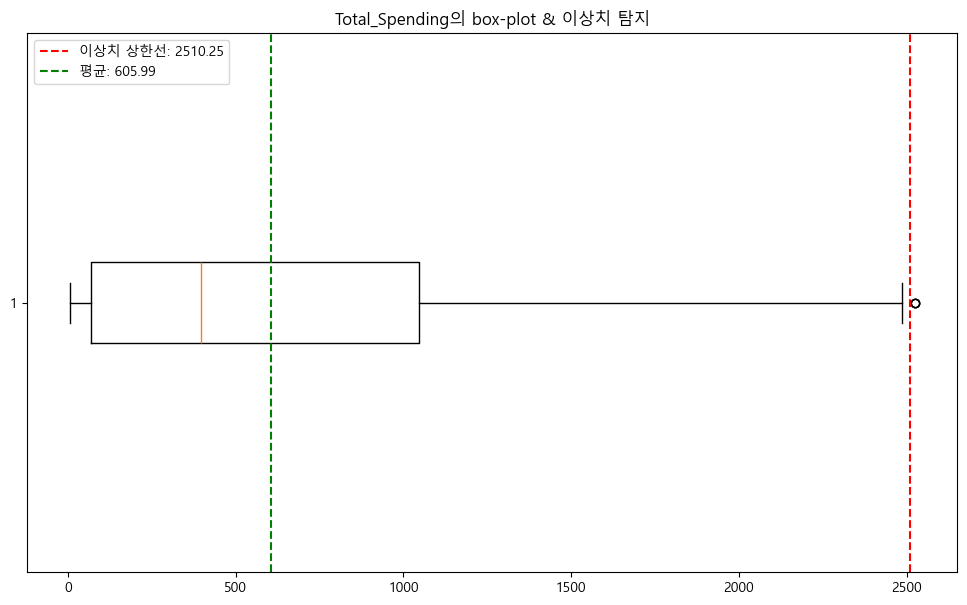

이상치 개수: 3


In [7]:
# TODO 1-2(b): Total_Spending 박스플롯 + IQR 기준 이상치
col = 'Total_Spending'
fig, ax = plt.subplots(1,1,figsize=(12, 7))
plt.boxplot(df[col],vert=False) # vert를 False로 지정하면 수평 박스플롯을 얻을 수 있음.
iqr = df[col].quantile(0.75) - df[col].quantile(0.25)
lower_outliers = df[col].quantile(0.25) - iqr * 1.5
higher_outliers = df[col].quantile(0.75) + iqr * 1.5
cnt_outliers = df[
    (df[col] >= higher_outliers) |
    (df[col] <= lower_outliers) 
]
mean = df['Total_Spending'].mean()
plt.axvline(higher_outliers, color='red', linestyle='--', label=f'이상치 상한선: {higher_outliers:.2f}')
plt.axvline(mean, color='green', linestyle='--', label=f'평균: {mean:.2f}')
plt.title(f'{col}의 box-plot & 이상치 탐지')
plt.legend()
plt.show()
print(f'이상치 개수: {len(cnt_outliers)}')

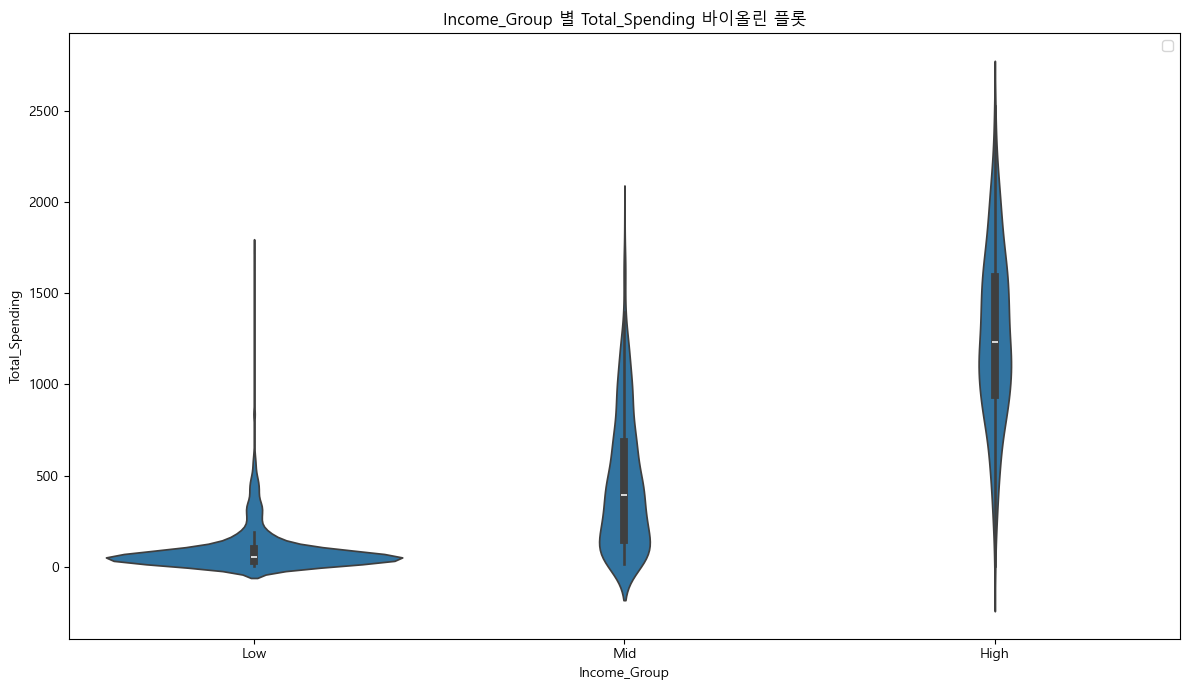

In [8]:
# TODO 1-2(c): Income_Group별 Total_Spending 바이올린 플롯
plt.figure(figsize=(12,7))
sns.violinplot(x='Income_Group', y='Total_Spending', data=df) # 바이올린 플랏이 너무 못생겨서 오렌지색 씀
plt.title('Income_Group 별 Total_Spending 바이올린 플롯')
plt.legend()
plt.tight_layout()
plt.show()

### 문제 1-3. 왜도와 첨도

6개 소비 카테고리(MntWines ~ MntGoldProds)의 왜도(Skewness)와 첨도(Kurtosis)를 계산하고,
2×3 히스토그램 그리드를 그려 분포 형태를 비교하세요.

**왜도 해석**
- 왜도 > 0: 오른쪽 꼬리가 긴 분포 
- 왜도 < 0: 왼쪽 꼬리가 긴 분포 
- 왜도 ≈ 0: 좌우 대칭에 가까운 분포

**첨도 해석** 
- 초과 첨도 > 0: 정규분포보다 중앙이 뾰족하고 꼬리가 두꺼운 분포 
- 초과 첨도 < 0: 정규분포보다 중앙이 평평하고 꼬리가 얇은 분포
- 초과 첨도 ≈ 0: 정규분포와 유사한 형태

In [9]:
spending_names = ['Wines', 'Fruits', 'Meat', 'Fish', 'Sweet', 'Gold']
hist_colors = [COLORS['blue'], COLORS['violet'], COLORS['teal'],
               COLORS['emerald'], COLORS['amber'], COLORS['rose']]

# TODO 1-3(a): 6개 카테고리의 왜도/첨도 계산 및 출력

# spending_names에 해당하는 컬럼 뽑기
spending_columns = [] # 새로운 리스트 생성
for c in df.columns: # 반복문 생성, c에 df의 컬럼들을 저장
    for s in spending_names: # 반복문 생성, s에 spending_names 요소들 저장
        if s in c: # s가 컬럼명 c에 속해있으면
            spending_columns.append(c) # 새 리스트에 저장
# 컬럼 뽑기 끝 !
print(spending_columns)

# 함수 만들기 (편하게 계산하자..)
def skewnkurt(data, col):
    skew = data[col].skew()
    kurt = data[col].kurt()
    final= pd.DataFrame({
        f'{col}': [skew, kurt]
    }, index=['왜도', '첨도'])
    return display(final)

for col in spending_columns:
    print(f'{col}의 왜도, 첨도')
    skewnkurt(df, col)

['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
MntWines의 왜도, 첨도


,MntWines
왜도,1.176036
첨도,0.600531


MntFruits의 왜도, 첨도


,MntFruits
왜도,2.104241
첨도,4.069754


MntMeatProducts의 왜도, 첨도


,MntMeatProducts
왜도,2.085282
첨도,5.530136


MntFishProducts의 왜도, 첨도


,MntFishProducts
왜도,1.91997
첨도,3.09602


MntSweetProducts의 왜도, 첨도


,MntSweetProducts
왜도,2.135674
첨도,4.372062


MntGoldProds의 왜도, 첨도


,MntGoldProds
왜도,1.885136
첨도,3.558349


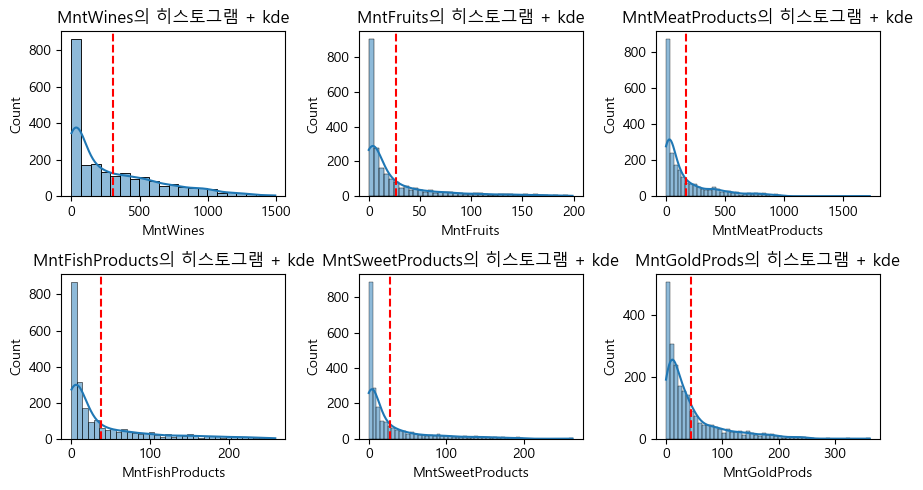

In [10]:
# TODO 1-3(b): 2×3 히스토그램 그리드 (각 카테고리 분포 + 평균선)

fig, axes = plt.subplots(2, 3, figsize=(9,5))
sns.histplot(df[spending_columns[0]], bins='auto', ax=axes[0,0], kde=True)
axes[0,0].set_title(f'{spending_columns[0]}의 히스토그램 + kde')
sns.histplot(df[spending_columns[1]], bins='auto', ax=axes[0,1], kde=True)
axes[0,1].set_title(f'{spending_columns[1]}의 히스토그램 + kde')
sns.histplot(df[spending_columns[2]], bins='auto', ax=axes[0,2], kde=True)
axes[0,2].set_title(f'{spending_columns[2]}의 히스토그램 + kde')
sns.histplot(df[spending_columns[3]], bins='auto', ax=axes[1,0], kde=True)
axes[1,0].set_title(f'{spending_columns[3]}의 히스토그램 + kde')
sns.histplot(df[spending_columns[4]], bins='auto', ax=axes[1,1], kde=True)
axes[1,1].set_title(f'{spending_columns[4]}의 히스토그램 + kde')
sns.histplot(df[spending_columns[5]], bins='auto', ax=axes[1,2], kde=True)
axes[1,2].set_title(f'{spending_columns[5]}의 히스토그램 + kde')

# 평균선 만들기
mean = df[spending_columns[0]].mean()
axes[0,0].axvline(mean, linestyle='--', color='red')
mean = df[spending_columns[1]].mean()
axes[0,1].axvline(mean, linestyle='--', color='red')
mean = df[spending_columns[2]].mean()
axes[0,2].axvline(mean, linestyle='--', color='red')
mean = df[spending_columns[3]].mean()
axes[1,0].axvline(mean, linestyle='--', color='red')
mean = df[spending_columns[4]].mean()
axes[1,1].axvline(mean, linestyle='--', color='red')
mean = df[spending_columns[5]].mean()
axes[1,2].axvline(mean, linestyle='--', color='red')

plt.tight_layout()
plt.show()

### 문제 1-4. 비즈니스 인사이트 정리

Part 1의 분석 결과를 바탕으로 다음을 정리하세요.

1. 고객 특성 요약 (연령, 소득, 소비 특성)
2. 핵심 발견 사항 (분포 특성, 그룹 간 차이)
3. 후속 분석에서 검증할 가설 (최소 3개)

In [11]:
# TODO 1-4: 비즈니스 인사이트 정리
print('1. 고객 특성 요약 (연령, 소득, 소비 특성)')
print('연령은 평균, 중앙값, 절사평균이 비슷한 값을 가지므로 매우 안정적인 분포를 보인다. \n 변동계수는 21%로 다른 변수보다 작아 가장 균질한 특성을 가진다고 할 수 있다.')
print('소득은 평균, 중앙값, 절사평균이 비슷한 값을 가지므로 극단값의 영향이 크지 않아 보인다. \n 하지만 변동계수가 41%로 개인간의 소득차이는 존재함을 알 수 있다. ')
print('총 지출은 평균 > 중앙값 > 최빈값 이므로 소비분포가 강하게 우측 이상치의 영향을 받음을 알 수 있다. \n 변동계수를 보면 100%에 가까움으로 개인 간 소비격차가 매우 크다는 것을 알 수 있다.')

print('2. 핵심 발견 사항 (분포 특성, 그룹 간 차이)')
print('총 지출 box-plot을 보면 3개의 이상치가 존재함을 알 수 있고,  \n 이상치가 아니더라도 수염의 길이를 보았을 때 지출 금액은 매우 다양하게 분포하고 있음을 확인할 수 있다.')
print('소득에 따른 매출을 살펴보면, 저소득층의 대부분 사람들은 낮은 금액대의 총 지출을 보이는 것으로 나타났다. \n 중산층은 다양한 금액의 지출을 보이는 것으로 보인다. 저소득층보다는 높은 지출을 보이는 것으로 나타났다. \n 고소득층은 저소득층, 중산층에 비해 전반적으로 더 높은 금액대의 지출을 보이는 것으로 나타났다.')
print('3. 후속 분석에서 검증할 가설 (최소 3개)')
print('가설1: 고소득층의 총 지출이 저소득층 + 중산층 총 지출보다 클 것이다.')
print('가설2: 고소득층은 와인과 고기를 주로 구매할 것이다.')
print('가설3: 가장 매출이 높은 품목과 낮은 품목의 차이는 구매하는 사람들의 특성과 연관이 있을 것이다.')


1. 고객 특성 요약 (연령, 소득, 소비 특성)
연령은 평균, 중앙값, 절사평균이 비슷한 값을 가지므로 매우 안정적인 분포를 보인다. 
 변동계수는 21%로 다른 변수보다 작아 가장 균질한 특성을 가진다고 할 수 있다.
소득은 평균, 중앙값, 절사평균이 비슷한 값을 가지므로 극단값의 영향이 크지 않아 보인다. 
 하지만 변동계수가 41%로 개인간의 소득차이는 존재함을 알 수 있다. 
총 지출은 평균 > 중앙값 > 최빈값 이므로 소비분포가 강하게 우측 이상치의 영향을 받음을 알 수 있다. 
 변동계수를 보면 100%에 가까움으로 개인 간 소비격차가 매우 크다는 것을 알 수 있다.
2. 핵심 발견 사항 (분포 특성, 그룹 간 차이)
총 지출 box-plot을 보면 3개의 이상치가 존재함을 알 수 있고,  
 이상치가 아니더라도 수염의 길이를 보았을 때 지출 금액은 매우 다양하게 분포하고 있음을 확인할 수 있다.
소득에 따른 매출을 살펴보면, 저소득층의 대부분 사람들은 낮은 금액대의 총 지출을 보이는 것으로 나타났다. 
 중산층은 다양한 금액의 지출을 보이는 것으로 보인다. 저소득층보다는 높은 지출을 보이는 것으로 나타났다. 
 고소득층은 저소득층, 중산층에 비해 전반적으로 더 높은 금액대의 지출을 보이는 것으로 나타났다.
3. 후속 분석에서 검증할 가설 (최소 3개)
가설1: 고소득층의 총 지출이 저소득층 + 중산층 총 지출보다 클 것이다.
가설2: 고소득층은 와인과 고기를 주로 구매할 것이다.
가설3: 가장 매출이 높은 품목과 낮은 품목의 차이는 구매하는 사람들의 특성과 연관이 있을 것이다.


---
## Part 2: 확률분포 모델링 — "고객 행동은 어떤 패턴을 따르는가?"

실제 고객 데이터에 이론적 확률분포를 적합하여 고객 행동을 모델링합니다.

### 문제 2-1. 이항분포 — 캠페인 수락 모델링

`Response` 열에서 수락률 p를 계산하고, 이를 이항분포 B(n, p)에 적용합니다.

- **(a)** 10명 중 정확히 2명이 수락할 확률
  - B(n=10, p) 에서 P(X = 2) 계산

- **(b)** 10명 중 3명 이상이 수락할 확률
  - B(n=10, p) 에서 P(X ≥ 3) 계산

- **(c)** 이항분포 PMF 시각화
  - B(n=10, p) 의 모든 경우(X = 0, 1, ..., 10)에 대한
    이론 확률을 막대그래프로 그립니다.

- **(d)** n=100 으로 확장 — 세 가지 질문
  - **기대 수락자 수**: E(X) 계산
  - **15명 이상 수락 확률**: P(X ≥ 15) 계산
  - **90% 보장 최소 수락 수**: P(X ≤ k) ≥ 0.90 을 만족하는 최솟값 k 탐색

In [12]:
# TODO 2-1(a),(b): 수락률(p) 계산 + P(X=2), P(X≥3) 계산 및 출력
n_trial = 10
# 수락률 구하기
tmp = df['Response']
p = sum(tmp) / len(tmp)
p

binom_stat = stats.binom(n=n_trial, p=p)

# 확률 구하기
print(f'P(X=2) 일 확률 = {binom_stat.pmf(2):.2f}')
print(f'P(X>=3)일 확률 = {binom_stat.sf(2):.2f}')

P(X=2) 일 확률 = 0.28
P(X>=3)일 확률 = 0.18


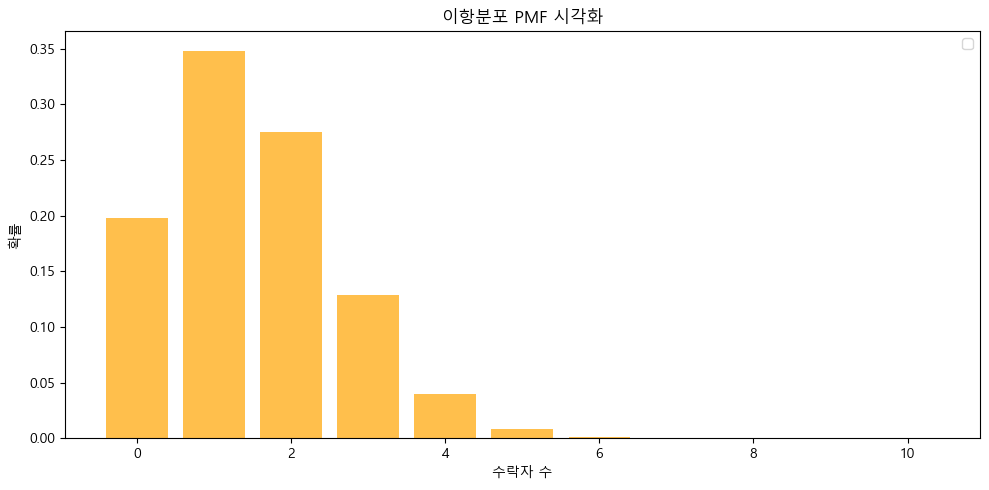

In [13]:
# TODO 2-1(c): 이항분포 PMF 시각화
k = np.arange(0,11)
pmf = binom_stat.pmf(k)
fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.bar(k,pmf,color='orange', alpha=0.7)
ax.set_title('이항분포 PMF 시각화')
ax.set_xlabel('수락자 수')
ax.set_ylabel('확률')
ax.legend()
plt.tight_layout()
plt.show()


In [14]:
# TODO 2-1(d): 100명 발송 시 기대 수락자, P(X≥15), 90% 보장 최소 수락 수
n_campaign = 100
binom_dist = stats.binom(n=n_campaign, p=p)

#- **(d)** n=100 으로 확장 — 세 가지 질문
#  - **기대 수락자 수**: E(X) 계산
print(f'기대 수락자 수 :{(binom_dist.mean()):.2f}명')

#  - **15명 이상 수락 확률**: P(X ≥ 15) 계산
print(f'15명 이상 수락 확률 P(X >= 15) = {binom_dist.sf(14):.2%}')

#  - **90% 보장 최소 수락 수**: P(X ≤ k) ≥ 0.90 을 만족하는 최솟값 k 탐색
print(f'90% 보장 최소 수락 수 P(X ≤ k) ≥ 0.90 = {binom_dist.ppf(0.9)}')

# 검정해보기
print(binom_dist.cdf(19)) # k= 19명일 때 = 0.8967795878065316
print(binom_dist.cdf(20)) # k= 20명일 때 = 0.9360207388842045


기대 수락자 수 :14.94명
15명 이상 수락 확률 P(X >= 15) = 53.58%
90% 보장 최소 수락 수 P(X ≤ k) ≥ 0.90 = 20.0
0.8967795878065316
0.9360207388842045


### 문제 2-2. 포아송 분포 — 웹사이트 방문 모델링

`NumWebVisitsMonth`(월간 웹 방문 수)에 포아송 분포를 적합합니다.

- **(a)** λ 추정 및 적합 평가
  - 표본 평균으로 λ를 추정하고,
    표본 평균 ≈ 표본 분산인지 확인하여 포아송 분포 적합 여부를 평가합니다.

- **(b)** 실측 vs 이론 PMF 시각화
  - 각 방문 횟수(0회, 1회, 2회, ...)별 실제 비율(실측 PMF)과
    포아송 분포의 이론 확률(이론 PMF)을 막대그래프로 겹쳐 그려 비교합니다.

- **(c)** 포아송 분포 활용 — 두 가지 실무 시나리오
  - **과다 방문 고객 비율**: P(X ≥ 10) 계산
    → 추정된 포아송 분포에서 월 10회 이상 방문할 확률이 몇 %인지 구합니다.
  - **서버 용량 계획**: 상위 5% 기준값 k 계산, 즉 P(X ≤ k) = 0.95 를 만족하는 k 탐색
    → 전체 고객의 95%를 커버할 수 있는 최대 방문 횟수를 구하고,
       이를 서버가 처리해야 할 기준 용량으로 활용합니다.

In [15]:
web_visits = df['NumWebVisitsMonth']

# TODO 2-2(a): 람다 추정 및 포아송 적합 평가 (월간 웹 방문수 평균≈분산 값이 비슷한지 확인)
lam = web_visits.mean()
poisson_dist = stats.poisson(mu=lam)

print(f'월간 웹 방문수 평균 = {poisson_dist.mean()}')
print(f'월간 웹 방문수 분산 = {poisson_dist.var()}')
print('평균과 분산이 동일하므로 포아송 적합함!')


월간 웹 방문수 평균 = 5.318872987477639
월간 웹 방문수 분산 = 5.318872987477639
평균과 분산이 동일하므로 포아송 적합함!


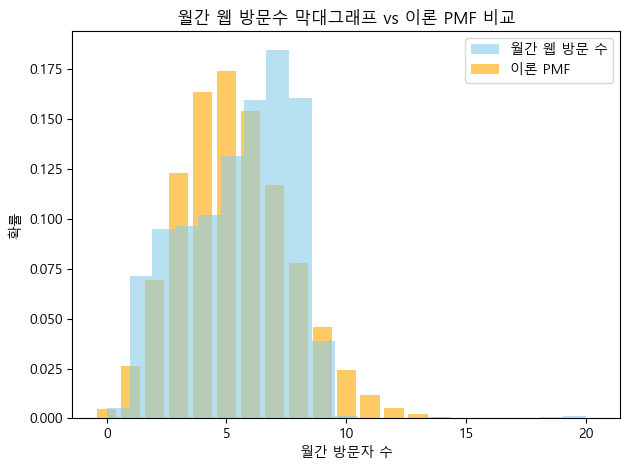

In [16]:
# TODO 2-2(b): 월간 웹 방문수 막대그래프 vs 이론 PMF 비교 시각화 (두 그래프를 겹쳐서 그리기)
n = np.arange(np.min(web_visits), np.max(web_visits) + 1, 1)
pmf = poisson_dist.pmf(n)

plt.bar(n,pmf,alpha=0.6,color='orange', label='이론 PMF')
plt.hist(web_visits, bins=len(n),density=True,alpha=0.6, color='skyblue', label='월간 웹 방문 수')
plt.xlabel('월간 방문자 수')
plt.ylabel('확률')
plt.title('월간 웹 방문수 막대그래프 vs 이론 PMF 비교')
plt.legend()
plt.tight_layout()

In [17]:
# TODO 2-2(c):
# - 과다 방문 고객: 포아송 분포로 P(X ≥ 10) 계산 (월 10회 이상 방문 확률)
# - 서버 용량 계획: P(X ≤ k) ≥ 0.95 를 만족하는 최솟값 k 탐색 (상위 5% 기준)
heavy_threshold = 10
#  - **과다 방문 고객 비율**: P(X ≥ 10) 계산
#    → 추정된 포아송 분포에서 월 10회 이상 방문할 확률이 몇 %인지 구합니다.
print(f'과다 방문 고객 비율 P(X >= 10) = {poisson_dist.sf(heavy_threshold-1):.1%}')

#  - **서버 용량 계획**: 상위 5% 기준값 k 계산, 즉 P(X ≤ k) = 0.95 를 만족하는 k 탐색
#    → 전체 고객의 95%를 커버할 수 있는 최대 방문 횟수를 구하고,
#       이를 서버가 처리해야 할 기준 용량으로 활용합니다.
print(f'상위 5% 기준값 k = {poisson_dist.ppf(0.95)}')

과다 방문 고객 비율 P(X >= 10) = 4.5%
상위 5% 기준값 k = 9.0


### 문제 2-3. 정규분포 — 소득 모델링

`Income`에 정규분포를 적합합니다.
Part 1에서 Income의 왜도가 작고 평균≈중앙값임을 확인했습니다. 정규분포가 잘 맞을까요?

- **(a)** μ, σ 추정 후 CDF로 P(Income < 30000), P(Income > 80000) 계산,
 PPF로 상위 10% 소득 기준값 계산 — **이론 확률과 실측 비율을 비교**하세요
- **(b)** 히스토그램 + 정규 분포 PDF와 겹쳐 그리기
- **(c)** 정규분포 활용 — 두 가지 질문
  - **VIP 기준선**: 상위 5% 소득 기준값
    → "이 금액 이상이면 VIP 고객으로 분류"
  - **할인 대상 기준선**: 하위 10% 소득 기준값
    → "이 금액 이하이면 할인 대상 고객으로 분류"


In [18]:
# TODO 2-3(a): μ, σ 추정 → CDF로 P(Income<30000), P(Income>80000) 계산
#               PPF로 상위 10% 소득 기준값 계산 → 이론 확률과 실측 비율 비교

mu = df['Income'].mean()
sigma = df['Income'].std()

norm_dist = stats.norm(loc=mu, scale=sigma)

print(f'P(Income<30000) = {norm_dist.cdf(29999)}')
print(f'P(Income>80000) = {1 - norm_dist.cdf(80000)}')
print(f'상위 10% 소득 기준값 계산 = {norm_dist.ppf(0.9)}')

P(Income<30000) = 0.1526060134466491
P(Income>80000) = 0.09511083952500887
상위 10% 소득 기준값 계산 = 79392.51290587384


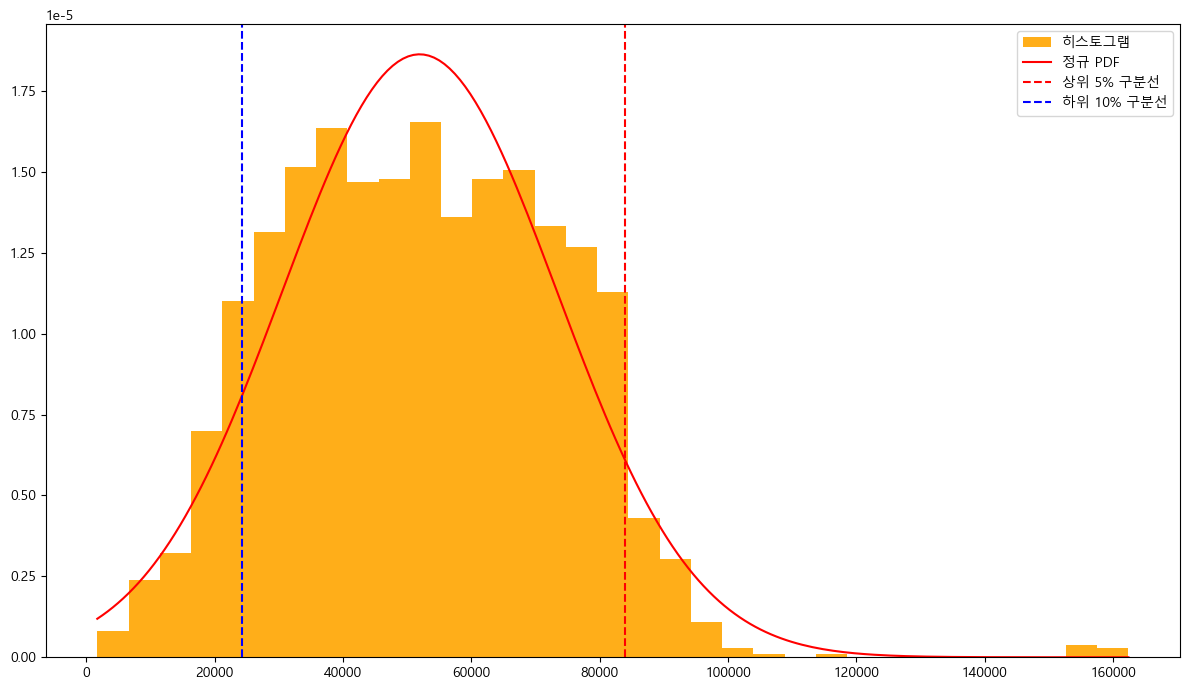

In [19]:
# TODO 2-3(b): 히스토그램 + 정규 PDF 겹쳐 그리기
n = np.linspace(np.min(df['Income']), np.max(df['Income']), 200)
pdf = norm_dist.pdf(n)
top5pro = df['Income'].quantile(0.95)
bot10pro = df['Income'].quantile(0.1)
plt.figure(figsize=(12,7))
plt.hist(df['Income'], bins='auto', alpha=0.9, density=True, color='orange', label='히스토그램')
# 정규분포 pdf
plt.plot(n, pdf, color='red', label='정규 PDF')
plt.axvline(top5pro, linestyle='--', color='red', label='상위 5% 구분선')
plt.axvline(bot10pro, linestyle='--', color='blue', label='하위 10% 구분선')
plt.legend()
plt.tight_layout()

In [20]:
# TODO 2-3(c): 실무 시나리오 — VIP(상위 5%) 기준선 + 할인 대상(하위 10%) 기준선
print(f'상위 5%(VIP) 기준선 = {top5pro}')
print(f'하위 10%(할인 대상) 기준선 = {bot10pro}')


상위 5%(VIP) 기준선 = 83897.5
하위 10%(할인 대상) 기준선 = 24213.5


---
## Part 3: 추정과 가설검정 — "고소득 고객과 저소득 고객의 소비는 다른가?"

신뢰구간과 가설검정을 통해 고객 그룹 간 차이를 통계적으로 검증합니다.

### 문제 3-1. 신뢰구간 추정

- **(a)** Total_Spending 평균의 90%, 95%, 99% 신뢰구간을 계산하세요.
- **(b)** Income_Group별 95% CI를 계산하고 오차막대 그래프로 비교하세요.

CI = [x̄ - t × SE, x̄ + t × SE] (SE = s / √n)

In [21]:
# TODO 3-1(a): Total_Spending 평균의 신뢰구간 (90%, 95%, 99%)
# CI = x̄ ± t(α/2, n-1) × SE

def confidence(series, confidence_level):
    mean = series.mean()
    std = series.std(ddof=1)
    n = len(series)
    se = std/np.sqrt(n)
    alpha = 1 - confidence_level
    t = stats.t.ppf(1-alpha/2, df=n-1)
    high = mean + t * se
    low = mean - t * se
    return low, high

for confidence_level in [0.90, 0.95, 0.99]:
    print(f'신뢰수준 {confidence_level:.1%} CI: {confidence(df['Total_Spending'], confidence_level)}')

신뢰수준 90.0% CI: (np.float64(585.0420537644019), np.float64(626.9311126041133))
신뢰수준 95.0% CI: (np.float64(581.0264644747788), np.float64(630.9467018937364))
신뢰수준 99.0% CI: (np.float64(573.1731693894566), np.float64(638.7999969790586))


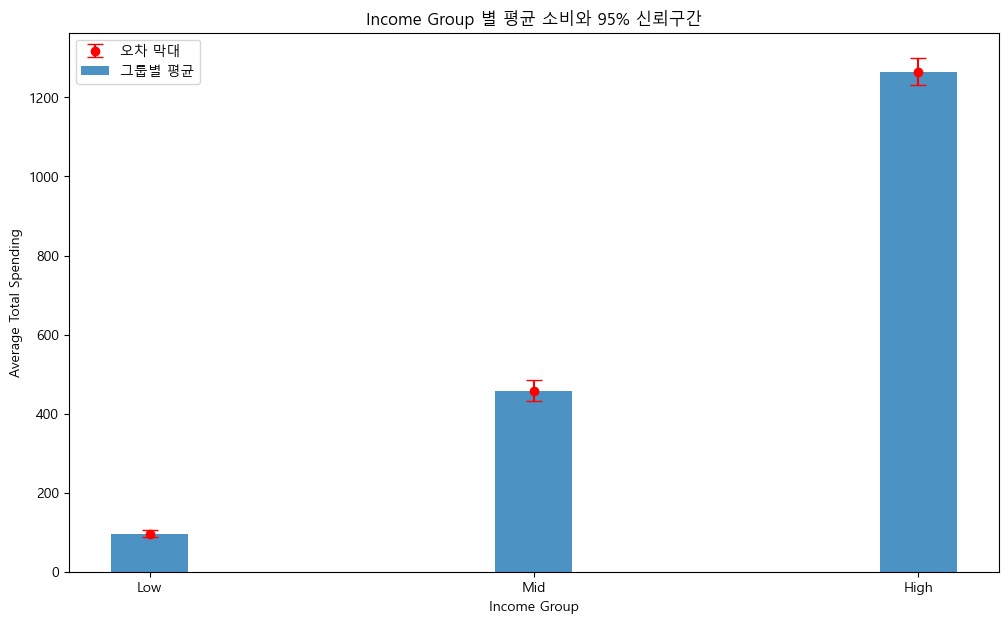

In [22]:
# TODO 3-1(b): Income_Group별 95% CI 계산 + 오차막대 그래프
summary = df.groupby('Income_Group')['Total_Spending'].agg(['mean', 'std', 'count']).reset_index()
alpha = 0.05
summary['low_95CI'] = summary['mean'] - (stats.t.ppf(1-alpha/2, df= summary['count']-1))*(summary['std']/np.sqrt(summary['count']))
summary['high_95CI'] = summary['mean'] + (stats.t.ppf(1-alpha/2, df= summary['count']-1))*(summary['std']/np.sqrt(summary['count']))
summary['yerr'] = summary['mean'] - summary['low_95CI']

plt.figure(figsize=(12,7))
plt.errorbar(
    summary['Income_Group'],
    summary['mean'],
    summary['yerr'],
    fmt='o',
    capsize=6,
    color='red',
    label='오차 막대'
)
plt.bar(summary['Income_Group'], summary['mean'], width=0.2, alpha=0.8, label='그룹별 평균')

plt.xlabel('Income Group')
plt.ylabel('Average Total Spending')
plt.title('Income Group 별 평균 소비와 95% 신뢰구간')
plt.legend()
plt.show()

### 문제 3-2. 독립표본 t-검정 (Welch's t-test)

**가설**: 자녀가 없는 고객의 총 소비가 자녀가 있는 고객과 다른가?

- H₀: μ_무자녀 = μ_유자녀
- H₁: μ_무자녀 ≠ μ_유자녀

Cohen's d 해석 기준: |d| < 0.5 작은, 0.5~0.8 중간, > 0.8 큰 효과

In [23]:
no_child = df[~df['Has_Children']]['Total_Spending']
yes_child = df[df['Has_Children']]['Total_Spending']

# TODO 3-2: Welch's t-검정 수행 + Cohen's d 계산 + 결과 출력
# Welch's t-검정
t_stat, p_value = stats.ttest_ind(no_child, yes_child, equal_var=False)
print(t_stat)
print(p_value)

# Cohen's d 계산
n1 = len(no_child)
n2 = len(yes_child)
var1 = np.var(no_child, ddof=1)
var2 = np.var(yes_child, ddof=1)
s_pooled = np.sqrt(((n1-1)*var1 + (n2-1)*var2)/(n1+n2-2))
cal_d = abs(np.mean(no_child) - np.mean(yes_child))/s_pooled

print(f"Cohen's d = {cal_d}")


24.98885267929026
6.321230429385628e-105
Cohen's d = 1.3598537468445944


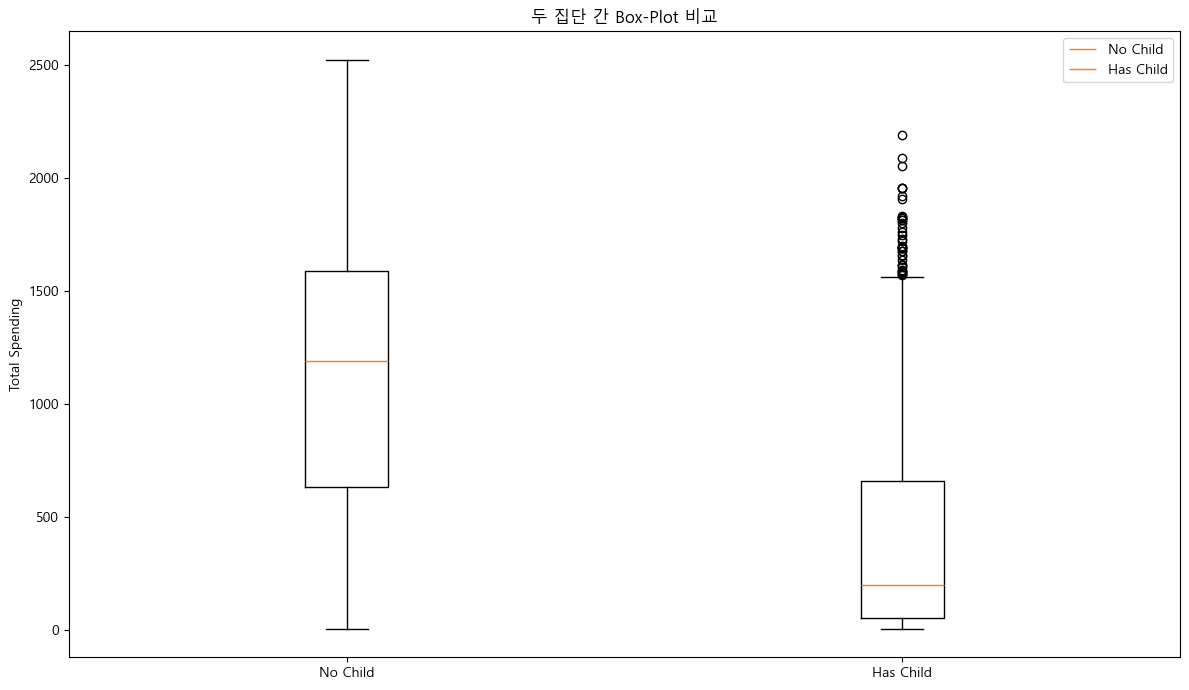

In [24]:
# TODO 3-2(c): 박스플롯 비교 시각화
plt.figure(figsize=(12,7))
plt.boxplot([no_child, yes_child], label=['No Child', 'Has Child'])
plt.xticks([1,2], ['No Child', 'Has Child'])
plt.ylabel('Total Spending')
plt.title('두 집단 간 Box-Plot 비교')
plt.legend()
plt.tight_layout()
plt.show()


### 문제 3-3. 대응표본 t-검정

같은 고객의 **와인 소비**(`MntWines`)와 **육류 소비**(`MntMeatProducts`)를 비교합니다.

- H₀: μ_Wine = μ_Meat (차이 = 0)
- H₁: μ_Wine ≠ μ_Meat

In [25]:
wines = df['MntWines']
meat = df['MntMeatProducts']
diff = wines - meat
# TODO 3-3: 차이 계산 + 대응표본 t-검정 + Cohen's d + 결과 출력
t_stat, p_value = stats.ttest_rel(wines, meat)
print(t_stat)
print(p_value)
d = np.abs(np.mean(diff)/np.std(diff, ddof=1))
print(d)

23.092889483443262
5.391926544698085e-106
0.488362577872471


In [26]:
summary = pd.DataFrame({
    '평균' : [wines.mean(), meat.mean()]
},index=['wines','meat']).reset_index(names='구분')
summary

,구분,평균
0,wines,304.127460
1,meat,166.983453


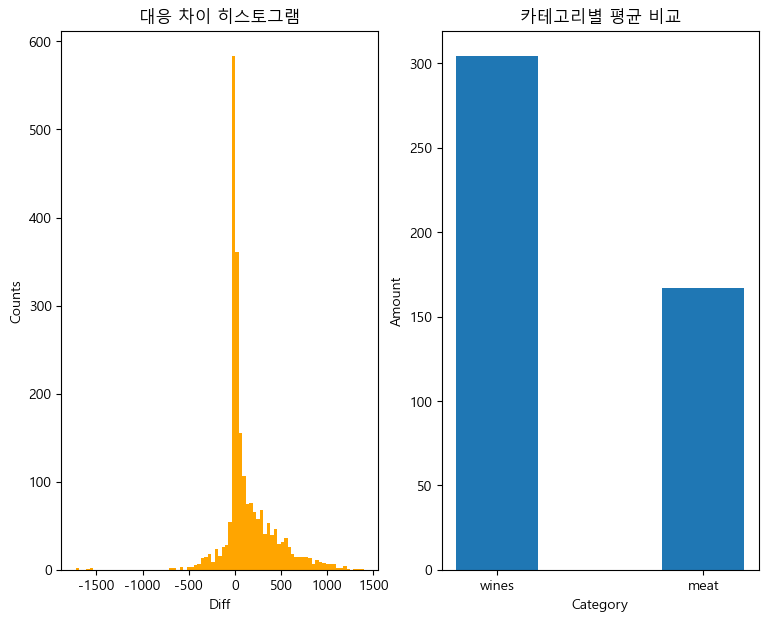

In [27]:
# TODO 3-3(b): (1) 대응 차이 히스토그램 (2) 카테고리별 평균 비교 막대그래프
fig, axes = plt.subplots(1, 2, figsize=(9,7))
axes[0].hist(diff, bins='auto',color='orange')
axes[0].set_xlabel('Diff')
axes[0].set_ylabel('Counts')
axes[0].set_title('대응 차이 히스토그램')

axes[1].bar(summary['구분'], summary['평균'], width=0.4)
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Amount')
axes[1].set_title('카테고리별 평균 비교')
plt.show()


### 문제 3-4. 검정력 분석

- **(a)** 문제 3-2의 효과 크기와 표본 크기를 사용하여 검정력(Power)을 계산하세요.
- **(b)** 작은 효과(d=0.2)를 탐지하기 위해 필요한 그룹당 표본 크기를 구하세요.

In [30]:
power_analysis = TTestIndPower()
# Cohen's d 계산
n1 = len(no_child)
n2 = len(yes_child)
var1 = np.var(no_child, ddof=1)
var2 = np.var(yes_child, ddof=1)
s_pooled = np.sqrt(((n1-1)*var1 + (n2-1)*var2)/(n1+n2-2))
cal_d = abs(np.mean(no_child) - np.mean(yes_child))/s_pooled

# TODO 3-4(a): 문제 3-2 기준 검정력 계산
t_crit = stats.t.ppf(0.05,df=n1+n2-2)


# TODO 3-4(b): 작은 효과(d=0.2) 탐지에 필요한 표본 크기 산정

---
## Part 4: 고급 검정 — "교육, 결혼, 캠페인 반응의 관계는?"

정규성 검정을 바탕으로 적절한 검정 방법을 선택하고,
범주형 변수 간 관계를 분석합니다.

### 문제 4-1. 정규성 + 등분산 검정

Education_Group별 Total_Spending의 정규성을 Shapiro-Wilk 검정과 Q-Q Plot으로 확인하세요.
정규성이 기각되더라도, 표본이 충분히 크면(n ≥ 30) 중심극한정리(CLT)에 의해
ANOVA가 여전히 강건(robust)합니다. 각 그룹의 표본 크기도 함께 확인하세요.

⚠️ **등분산성 위반은 CLT와 무관합니다** — 표본이 아무리 커도 해결되지 않습니다.
Levene 검정으로 등분산 가정을 확인하고, 위반 시 Welch's ANOVA를 사용합니다.

In [31]:
edu_groups = ['Undergraduate', 'Graduate', 'Postgraduate']


# TODO 4-1(a): Shapiro-Wilk 검정 (각 그룹별)
for i in edu_groups:
    temp = df.loc[df['Education_Group']==i, 'Total_Spending']
    stats_sw, p_value = stats.shapiro(temp)
    print(f'{i}의 shapiro 검정 결과 : stats = {stats_sw}, p-value = {p_value}, n = {len(temp)}')

# TODO 4-1(b): Levene 등분산 검정 → use_welch = True/False 설정
group_data = [
    df.loc[df['Education_Group']==i, 'Total_Spending'] for i in edu_groups
]
lev_stat, lev_p = stats.levene(*group_data)
if lev_p < 0.05 :
    use_welch = True
    print('등분산 위반(use_welch = True)')
else:
    use_welch = False
    print('등분산 가정 충족 (use_welch = False)')

Undergraduate의 shapiro 검정 결과 : stats = 0.7604908247215473, p-value = 5.543648052614619e-19, n = 255
Graduate의 shapiro 검정 결과 : stats = 0.874298605350791, p-value = 3.561909628976696e-29, n = 1126
Postgraduate의 shapiro 검정 결과 : stats = 0.8764736594870332, p-value = 1.7757879312718283e-25, n = 855
등분산 위반(use_welch = True)


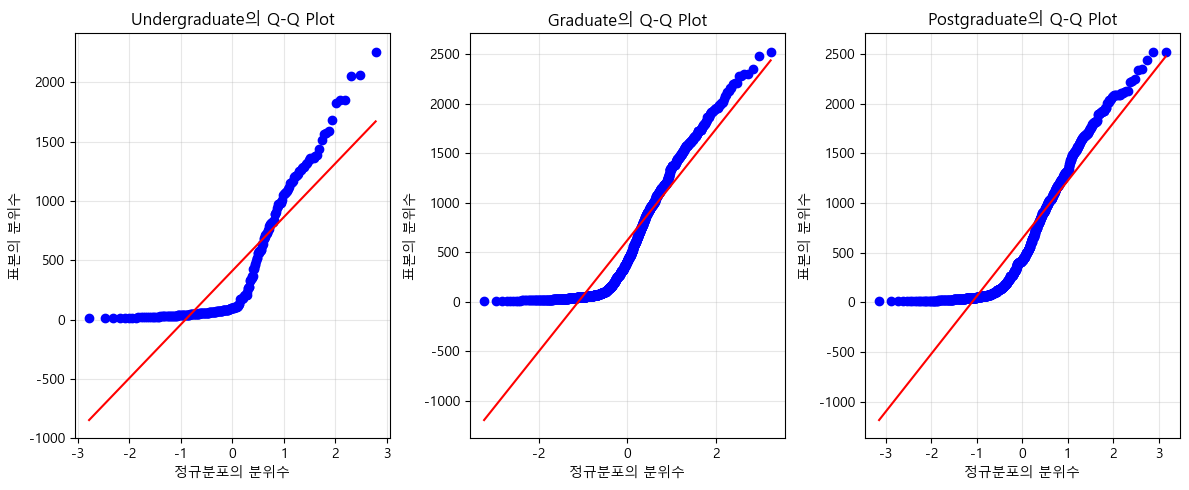

In [32]:
# TODO 4-1(b): Q-Q Plot (1×3 서브플롯)
fig, axes = plt.subplots(1,3,figsize=(12,5))
for i in edu_groups:
    temp = df.loc[df['Education_Group']==i, 'Total_Spending']
    idx = edu_groups.index(i)
    stats.probplot(temp, dist='norm',plot=axes[idx])
    axes[idx].set_title(f'{i}의 Q-Q Plot')
    axes[idx].set_xlabel('정규분포의 분위수')
    axes[idx].set_ylabel('표본의 분위수')
    axes[idx].grid(alpha=0.3)
plt.tight_layout()
plt.show()

### 문제 4-2. ANOVA + 사후검정

문제 4-1의 정규성/등분산 검정 결과에 따라 적절한 검정을 수행합니다.

- 등분산 만족 → One-way ANOVA + **Tukey HSD** + Cohen's d
- 등분산 위반 → Welch's ANOVA + **Games-Howell** (`pg.pairwise_gameshowell()`) + Hedges' g
- 참고로 비모수 검정(Kruskal-Wallis)도 병행하여 결과의 일관성을 확인하세요.
- 효과 크기: η² + ω² (기준: 0.01 작은, 0.06 중간, 0.14 큰)
- 쌍별 효과 크기: Cohen's d / Hedges' g (기준: 0.2 미만 매우 작은, 0.2~0.5 작은, 0.5~0.8 중간, 0.8 이상 큰)

In [33]:
group_data = {
    g: df[df["Education_Group"] == g]["Total_Spending"].values for g in edu_groups
}
groups = list(group_data.values())
k = len(groups)

# TODO 4-2(a): use_welch에 따라 ANOVA / Welch's ANOVA 수행 (Kruskal-Wallis도 병행)stat
if not use_welch:
    f_stat, p_val = stats.f_oneway(*groups)
    print("\n[One-way ANOVA]")
    print(f"F = {f_stat:.4f}, p = {p_val:.4g}")
else:
    welch = pg.welch_anova(dv='Total_Spending', between='Education_Group', data=df)
    print("\n[Welch's ANOVA]")
    print(welch)

# Kruskal-Wallis
print("\nKruskal-Wallis")
h_stat, h_p = stats.kruskal(*groups)
print(f"H = {h_stat:.4f}, p = {h_p:.4g}")

# TODO 4-2(b): η² + ω² 계산 — ω² = (SS_between - (k-1)*MS_within) / (SS_total + MS_within)

# SS 계산
all_values = np.concatenate(groups)
grand_mean = np.mean(all_values)

ss_between = sum(len(group_data[g]) * (np.mean(group_data[g]) - grand_mean)**2 for g in edu_groups)
ss_within  = sum(np.sum((group_data[g] - np.mean(group_data[g]))**2) for g in edu_groups)
ss_total   = ss_between + ss_within

df_between = k - 1
df_within  = len(all_values) - k

ms_within = ss_within / df_within

eta_sq = ss_between / ss_total
omega_sq = (ss_between - df_between * ms_within) / (ss_total + ms_within)

print("\n[Effect size]")
print(f"η² = {eta_sq:.4f}")
print(f"ω² = {omega_sq:.4f}")



[Welch's ANOVA]
            Source  ddof1       ddof2          F         p-unc     np2
0  Education_Group      2  751.708152  19.817377  4.098696e-09  0.0137

Kruskal-Wallis
H = 36.6133, p = 1.121e-08

[Effect size]
η² = 0.0137
ω² = 0.0128


In [34]:
# TODO 4-2(c): 사후검정 수행 + 해석 + 쌍별 효과크기
# 등분산 만족 → Tukey HSD + Cohen's d
def cohens_d(x1, x2):
    n1, n2 = len(x1), len(x2)
    v1, v2 = np.var(x1, ddof=1), np.var(x2, ddof=1)
    s_pooled = np.sqrt(((n1-1)*v1 + (n2-1)*v2) / (n1+n2-2))
    return (np.mean(x1) - np.mean(x2)) / s_pooled

if not use_welch:
    print("\n[Tukey HSD]")
    tukey = pairwise_tukeyhsd(
        endog=df['Total_Spending'].replace([np.inf, -np.inf], np.nan).dropna(),
        groups=df.loc[df['Total_Spending'].replace([np.inf, -np.inf], np.nan).notna(), 'Education_Group'],
        alpha=0.05
    )
    print(tukey)

    print("\n[Pairwise Cohen's d]")
    rows = []
    for i in range(len(edu_groups)):
        for j in range(i+1, len(edu_groups)):
            g1, g2 = edu_groups[i], edu_groups[j]
            d = cohens_d(group_data[g1], group_data[g2])
            rows.append([g1, g2, d, abs(d)])
    pair_d = pd.DataFrame(rows, columns=['A','B',"cohens_d","abs_d"]).sort_values('abs_d', ascending=False)
    print(pair_d)

# 등분산 위반 → Games-Howell (pg.pairwise_gameshowell) + Hedges' g
def hedges_g(x1, x2):
    # Hedges' g = J * d  (J: small sample correction)
    n1, n2 = len(x1), len(x2)
    v1, v2 = np.var(x1, ddof=1), np.var(x2, ddof=1)
    s_pooled = np.sqrt(((n1-1)*v1 + (n2-1)*v2) / (n1+n2-2))
    d = (np.mean(x1) - np.mean(x2)) / s_pooled
    J = 1 - (3 / (4*(n1+n2) - 9))
    return d * J

if use_welch:
    print("\n[Games-Howell]")
    gh = pg.pairwise_gameshowell(dv='Total_Spending', between='Education_Group', data=df)
    # pingouin 결과에 hedges 컬럼이 같이 나옴
    print(gh[['A','B','mean(A)','mean(B)','pval','hedges']])

    print("\n[Pairwise Hedges' g (manual)]")
    rows = []
    for i in range(len(edu_groups)):
        for j in range(i+1, len(edu_groups)):
            g1, g2 = edu_groups[i], edu_groups[j]
            gval = hedges_g(group_data[g1], group_data[g2])
            rows.append([g1, g2, gval, abs(gval)])
    pair_g = pd.DataFrame(rows, columns=['A','B',"hedges_g","abs_g"]).sort_values('abs_g', ascending=False)
    print(pair_g)




[Games-Howell]
              A              B     mean(A)     mean(B)          pval    hedges
0      Graduate   Postgraduate  620.394316  644.791813  6.523632e-01 -0.040121
1      Graduate  Undergraduate  620.394316  412.254902  8.920656e-08  0.355688
2  Postgraduate  Undergraduate  644.791813  412.254902  9.577128e-09  0.389636

[Pairwise Hedges' g (manual)]
               A             B  hedges_g     abs_g
1  Undergraduate  Postgraduate -0.389636  0.389636
0  Undergraduate      Graduate -0.355688  0.355688
2       Graduate  Postgraduate -0.040121  0.040121


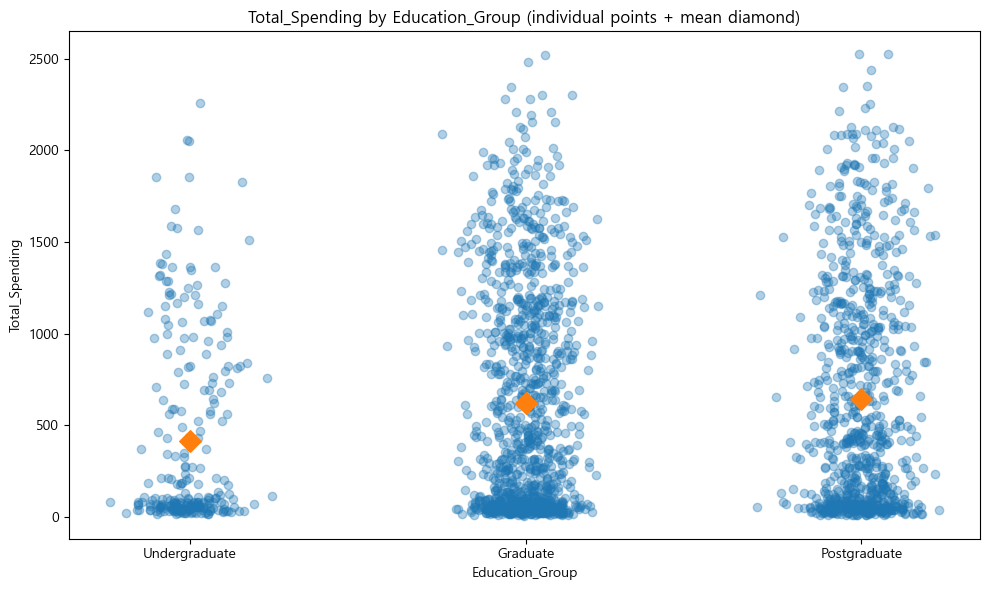

In [35]:
# TODO 4-2(d): 시각화 — 그룹별 개별 데이터 산점도 + 평균 다이아몬드
# 시각화를 위한 데이터(결측 제거)
plot_df = df[['Education_Group','Total_Spending']].copy()
plot_df['Total_Spending'] = plot_df['Total_Spending'].replace([np.inf, -np.inf], np.nan)
plot_df = plot_df.dropna()

# x축 위치 매핑
x_map = {g:i for i,g in enumerate(edu_groups)}
x = plot_df['Education_Group'].map(x_map).values

# jitter
rng = np.random.default_rng(0)
jitter = rng.normal(0, 0.08, size=len(plot_df))  # 지터 강도 조절 가능
x_j = x + jitter

plt.figure(figsize=(10,6))
plt.scatter(x_j, plot_df['Total_Spending'].values, alpha=0.35)

# 그룹 평균(다이아몬드)
means = [np.mean(group_data[g]) for g in edu_groups]
plt.scatter(range(len(edu_groups)), means, marker='D', s=120)

plt.xticks(range(len(edu_groups)), edu_groups, rotation=0)
plt.xlabel("Education_Group")
plt.ylabel("Total_Spending")
plt.title("Total_Spending by Education_Group (individual points + mean diamond)")
plt.tight_layout()
plt.show()


### 문제 4-3. 카이제곱 독립성 검정

**가설**: 결혼 상태(Marital_Group)와 캠페인 반응(Campaign_Response)은 독립인가?

- H₀: Marital_Group과 Campaign_Response는 독립이다.
- H₁: 두 변수는 독립이 아니다.

- 효과크기: φ (phi) = √(χ² / n) (기준: 0.1 작은, 0.3 중간, 0.5 큰)
- 오즈비(Odds Ratio): OR = (a×d) / (b×c), 95% CI = exp(ln(OR) ± 1.96 × SE)

> ⚠️ Cochran 규칙: 기대빈도 < 5인 셀이 전체의 20% 초과 시 Fisher 정확검정 필요

In [36]:
crosstab_no_margin = pd.crosstab(df['Marital_Group'], df['Campaign_Response'])

# TODO 4-3(a): 카이제곱 검정 수행 + Cochran 규칙 확인

# 교차표
ct = pd.crosstab(df['Marital_Group'], df['Campaign_Response'])
print("[Contingency Table]")
print(ct)

# 카이제곱 검정
chi2, p, dof, expected = stats.chi2_contingency(ct)
print("\n[Chi-square Test]")
print(f"χ² = {chi2:.4f}, dof = {dof}, p = {p:.4g}")

# 기대빈도 표
expected_df = pd.DataFrame(expected, index=ct.index, columns=ct.columns)
print("\n[Expected Frequencies]")
print(expected_df)

# Cochran 규칙 확인
small_cells = (expected < 5).sum()
total_cells = expected.size
ratio_small = small_cells / total_cells

print(f"\n기대빈도 < 5 셀 비율: {ratio_small:.2%}")

if ratio_small > 0.2:
    print("Cochran 규칙 위반 → Fisher 정확검정 고려")
else:
    print("Cochran 규칙 충족")

# TODO 4-3(b): φ (phi) 계산

n = ct.values.sum()
phi = np.sqrt(chi2 / n)
print(f"\n[Effect Size: Phi] φ = {phi:.4f}")

# TODO 4-3(c): 오즈비(Odds Ratio) + 95% CI 계산

if ct.shape == (2,2):
    a, b, c, d = ct.values.flatten()
    
    OR = (a*d) / (b*c)
    
    # 표준오차
    SE = np.sqrt(1/a + 1/b + 1/c + 1/d)
    
    # 신뢰구간
    CI_lower = np.exp(np.log(OR) - 1.96*SE)
    CI_upper = np.exp(np.log(OR) + 1.96*SE)
    
    print("\n[Odds Ratio]")
    print(f"OR = {OR:.4f}")
    print(f"95% CI = ({CI_lower:.4f}, {CI_upper:.4f})")
else:
    print("\nOR 계산은 2x2 테이블에서만 가능합니다.")



[Contingency Table]
Campaign_Response  False  True 
Marital_Group                  
Single               547    247
Together            1081    361

[Chi-square Test]
χ² = 9.2368, dof = 1, p = 0.002372

[Expected Frequencies]
Campaign_Response        False       True 
Marital_Group                             
Single              578.100179  215.899821
Together           1049.899821  392.100179

기대빈도 < 5 셀 비율: 0.00%
Cochran 규칙 충족

[Effect Size: Phi] φ = 0.0643

[Odds Ratio]
OR = 0.7396
95% CI = (0.6105, 0.8959)


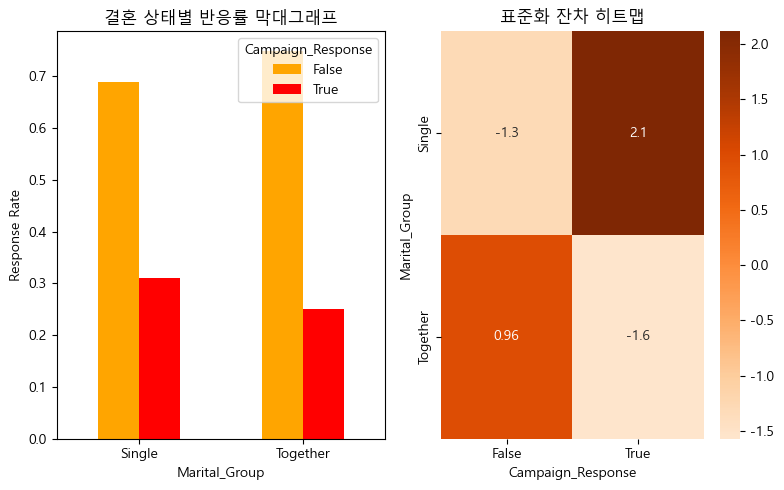

In [37]:
# TODO 4-3(d): (1) 결혼 상태별 반응률 막대그래프 (2) 표준화 잔차 히트맵

fig, axes = plt.subplots(1,2,figsize=(12,7))
response_rate = ct.div(ct.sum(axis=1), axis=0)
response_rate.plot(kind='bar', figsize=(8,5), color=['orange','red'],ax=axes[0])
axes[0].set_ylabel("Response Rate")
axes[0].set_title("결혼 상태별 반응률 막대그래프")
axes[0].tick_params(axis='x', rotation=0)

# 표준화 잔차 히트맵 만들기
std_resid = (ct - expected_df) / np.sqrt(expected_df)
sns.heatmap(std_resid, annot=True, cmap='Oranges', ax=axes[1], center=0)
axes[1].set_title('표준화 잔차 히트맵')
plt.tight_layout()
plt.show()

### 문제 4-4. 적합도 검정

3개 구매 채널(Web, Catalog, Store)의 총 구매 비율이 균등하게 분포하는지 검정합니다.

- H₀: 세 채널의 구매 비율이 동일하다 (1/3 : 1/3 : 1/3)
- H₁: 세 채널의 구매 비율이 동일하지 않다

Cohen's w = √(Σ(p_obs - p_exp)² / p_exp)

In [38]:
channel_totals = df[purchase_cols].sum()
channel_names = ['Web', 'Catalog', 'Store']
observed = channel_totals.values

# TODO 4-4(a): 기대빈도(균등) 계산 + 적합도 검정
n_total = observed.sum()
expected = np.repeat(n_total / 3, 3)
print("Observed:", observed)
print("Expected (Uniform):", expected)

# 카이제곱 적합도 검정
chi2, p = stats.chisquare(f_obs=observed, f_exp=expected)

print("\n[Goodness-of-Fit Test]")
print(f"χ² = {chi2:.4f}")
print(f"p-value = {p:.4g}")

# TODO 4-4(b): Cohen's w 계산
# 비율로 변환
p_obs = observed / n_total
p_exp = np.repeat(1/3, 3)

w = np.sqrt(np.sum((p_obs - p_exp)**2 / p_exp))

print("\n[Cohen's w]")
print(f"w = {w:.4f}")


Observed: [ 9140  5955 12959]
Expected (Uniform): [9351.33333333 9351.33333333 9351.33333333]

[Goodness-of-Fit Test]
χ² = 2630.1063
p-value = 0

[Cohen's w]
w = 0.3062


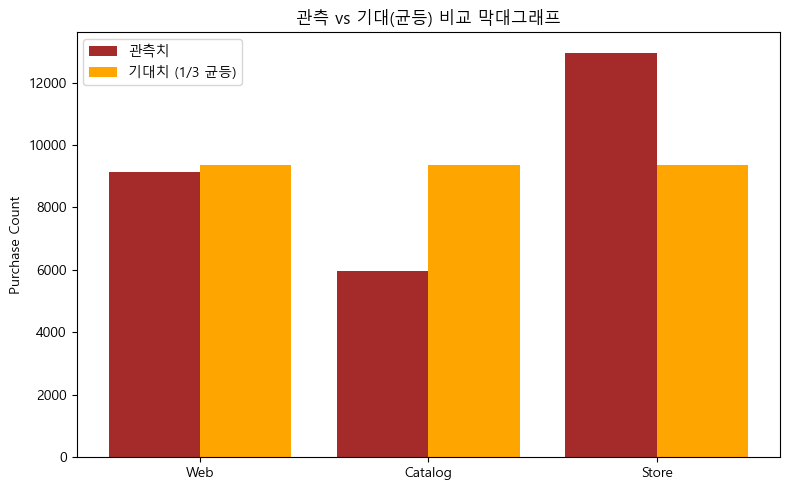

In [39]:
# TODO 4-4(c): 관측 vs 기대(균등) 비교 막대그래프
x = np.arange(len(channel_names))

plt.figure(figsize=(8,5))
plt.bar(x - 0.2, observed, width=0.4, label='관측치', color='brown')
plt.bar(x + 0.2, expected, width=0.4, label='기대치 (1/3 균등)', color='orange')

plt.xticks(x, channel_names)
plt.ylabel("Purchase Count")
plt.title("관측 vs 기대(균등) 비교 막대그래프")
plt.legend()
plt.tight_layout()
plt.show()


---
## Part 5: 상관분석 / 비율 비교 — "변수 간 관계를 파악하고, 캠페인 효과를 검증할 수 있는가?"

변수 간 상관관계를 분석하고, A/B 테스트로 캠페인 효과를 검증합니다.

### 문제 5-1. 상관분석

6개 변수의 Pearson/Spearman 상관계수를 계산하고 히트맵으로 시각화하세요.
주요 변수 쌍에 대해 유의성 검정도 수행합니다.

In [40]:
corr_vars = [
    "Income",
    "Age",
    "Total_Spending",
    "Total_Purchases",
    "NumWebVisitsMonth",
    "Recency",
]
corr_df = df[corr_vars]

# TODO 5-1(a): Pearson/Spearman 상관행렬 계산
pearson_corr = corr_df.corr(method="pearson")
spearman_corr = corr_df.corr(method="spearman")
print("pearson 상관계수 :")
display(pearson_corr)
print("spearman 상관계수 :")
display(spearman_corr)

# TODO 5-1(b): 주요 상관계수 쌍의 유의성 검정 (stats.pearsonr)
pairs = [
    ('Income', 'Total_Spending'),
    ('Total_Spending', 'Total_Purchases'),
    ('NumWebVisitsMonth', 'Total_Spending')
]
print("\n[Significance Test - Pearson]")
for x, y in pairs:
    r, p = stats.pearsonr(corr_df[x], corr_df[y])
    print(f"{x} vs {y}: r = {r:.4f}, p = {p:.4g}")

pearson 상관계수 :


,Income,Age,Total_Spending,Total_Purchases,NumWebVisitsMonth,Recency
Income,1.000000,0.198835,0.789375,0.738647,-0.646382,0.007829
Age,0.198835,1.000000,0.113618,0.173004,-0.117498,0.019396
Total_Spending,0.789375,0.113618,1.000000,0.821091,-0.499909,0.020842
Total_Purchases,0.738647,0.173004,0.821091,1.000000,-0.426734,0.006426
NumWebVisitsMonth,-0.646382,-0.117498,-0.499909,-0.426734,1.000000,-0.021850
Recency,0.007829,0.019396,0.020842,0.006426,-0.021850,1.000000


spearman 상관계수 :


,Income,Age,Total_Spending,Total_Purchases,NumWebVisitsMonth,Recency
Income,1.000000,0.216515,0.849491,0.776796,-0.640295,0.009743
Age,0.216515,1.000000,0.157677,0.179340,-0.129426,0.020109
Total_Spending,0.849491,0.157677,1.000000,0.908447,-0.476821,0.019979
Total_Purchases,0.776796,0.179340,0.908447,1.000000,-0.420867,0.011726
NumWebVisitsMonth,-0.640295,-0.129426,-0.476821,-0.420867,1.000000,-0.022259
Recency,0.009743,0.020109,0.019979,0.011726,-0.022259,1.000000



[Significance Test - Pearson]
Income vs Total_Spending: r = 0.7894, p = 0
Total_Spending vs Total_Purchases: r = 0.8211, p = 0
NumWebVisitsMonth vs Total_Spending: r = -0.4999, p = 1.073e-141


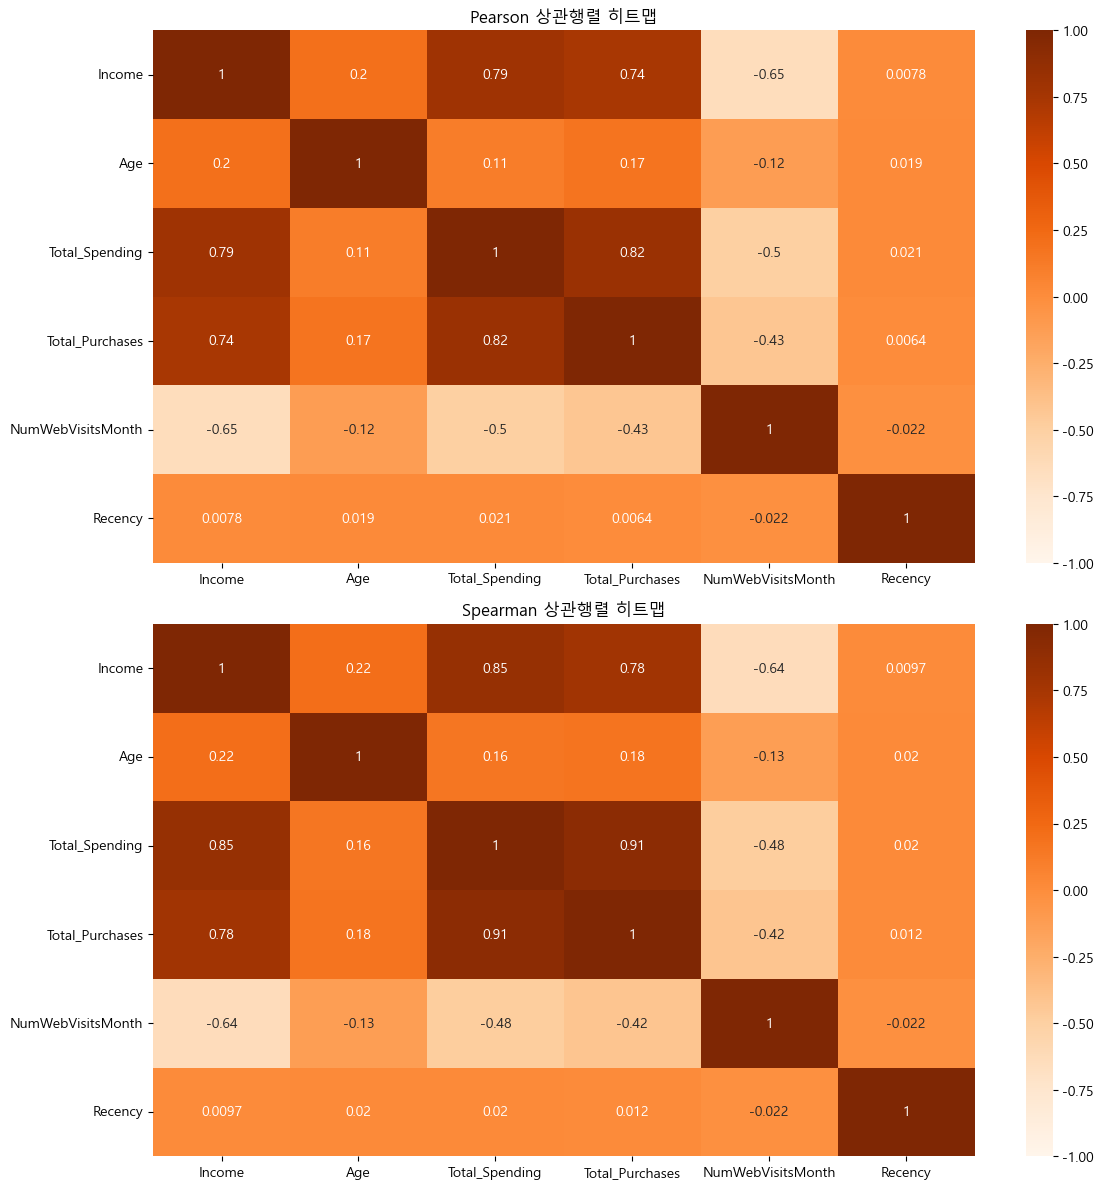

In [41]:
# TODO 5-1(c): 상관행렬 히트맵 (Pearson + Spearman, 1×2 서브플롯)
fig, axes = plt.subplots(2,1,figsize=(12,12)) # 1x2는 결과가 잘 안보여서 2x1로 수정했습니다.. 
sns.heatmap(pearson_corr, cmap='Oranges', annot=True, center=0, ax=axes[0],vmin=-1, vmax=1)
axes[0].set_title('Pearson 상관행렬 히트맵')

sns.heatmap(spearman_corr, cmap='Oranges', annot=True, center=0, ax=axes[1],vmin=-1, vmax=1)
axes[1].set_title('Spearman 상관행렬 히트맵')

plt.tight_layout()
plt.show()


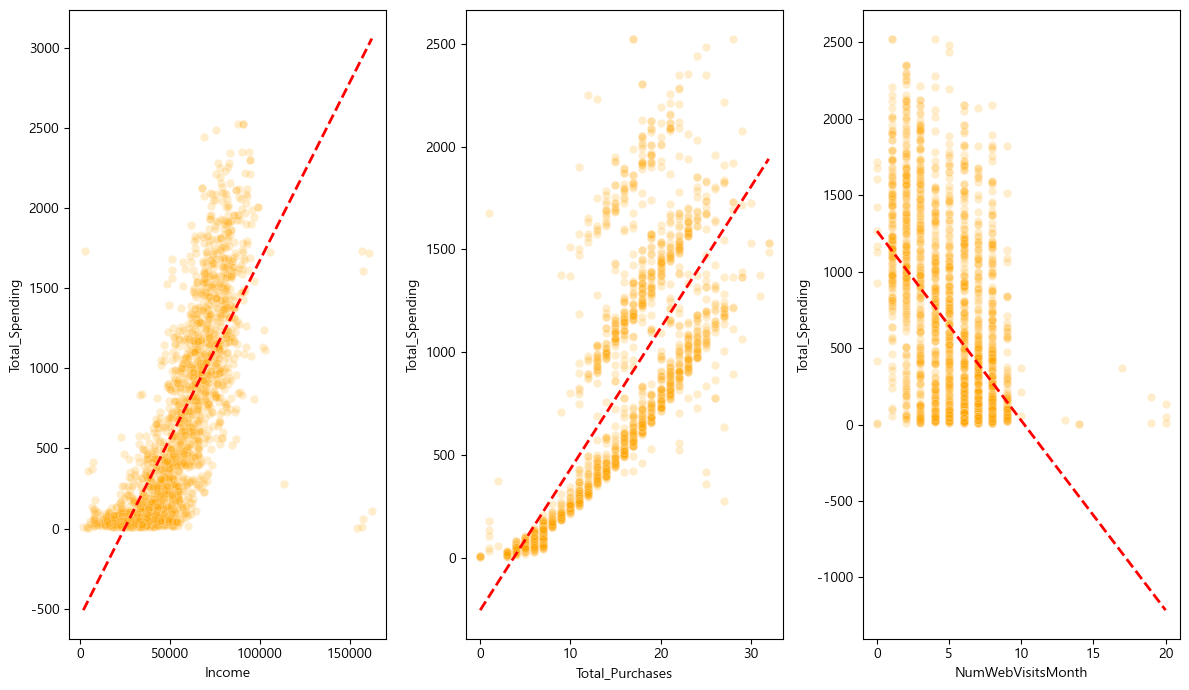

In [66]:
# TODO 5-1(d): 주요 변수 쌍 산점도 + 추세선 (1×3 서브플롯)
# 대상: (Income, Total_Spending), (NumWebVisitsMonth, Total_Spending), (Total_Spending, Total_Purchases)
# np.polyfit()으로 1차 추세선을 그리세요

fig, axes = plt.subplots(1, 3, figsize=(12,7))
sns.scatterplot(x=df[pairs[0][0]], y=df[pairs[0][1]], color='Orange', ax=axes[0], alpha=0.2)
sns.scatterplot(x=df[pairs[1][1]], y=df[pairs[1][0]], color='Orange', ax=axes[1], alpha=0.2)
sns.scatterplot(x=df[pairs[2][0]], y=df[pairs[2][1]], color='Orange', ax=axes[2], alpha=0.2)

z1 = np.polyfit(df[pairs[0][0]], df[pairs[0][1]], 1)
p1 = np.poly1d(z1)
x_line1 = np.linspace(df[pairs[0][0]].min(), df[pairs[0][0]].max(),100)

z2 = np.polyfit(df[pairs[1][1]], df[pairs[1][0]], 1)
p2 = np.poly1d(z2)
x_line2 = np.linspace(df[pairs[1][1]].min(), df[pairs[1][1]].max(),100)

z3 = np.polyfit(df[pairs[2][0]], df[pairs[2][1]], 1)
p3 = np.poly1d(z3)
x_line3 = np.linspace(df[pairs[2][0]].min(), df[pairs[2][0]].max(),100)
axes[0].plot(x_line1, p1(x_line1), color='red', linewidth=2, linestyle='--', label=f'회귀선: y={z1[0]:.2f}x + {z1[1]:.1f}')
axes[1].plot(x_line2, p2(x_line2), color='red', linewidth=2, linestyle='--', label=f'회귀선: y={z2[0]:.2f}x + {z2[1]:.1f}')
axes[2].plot(x_line3, p3(x_line3), color='red', linewidth=2, linestyle='--', label=f'회귀선: y={z3[0]:.2f}x + {z3[1]:.1f}')
plt.tight_layout()
plt.show()

### 문제 5-2. 두 그룹 비율 비교 (관찰 연구)

이전 캠페인 반응 경험 유무에 따라 마지막 캠페인(Response) 수락률에 차이가 있는지 검증합니다.

- **Group A**: AcceptedCmp1~5 합계 = 0 (이전 캠페인 무반응)
- **Group B**: AcceptedCmp1~5 합계 ≥ 1 (이전 캠페인 반응 경험)
- **지표**: Response (마지막 캠페인 수락률)
- **검정 방법**: z-비율검정 + Cohen's h + Wilson 신뢰구간

> **주의**: 이 분석은 A/B 테스트가 **아닙니다**. \
> A/B 테스트는 연구자가 참가자를 **무작위로 배정** (Random Assignment)하는 실험입니다. \
> 여기서는 고객이 과거 행동에 의해 스스로 그룹에 배정되었으므로 **관찰 연구**이며, \
> 인과관계를 주장할 수 없습니다.

In [68]:
cmp_cols = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
df['Prior_Response'] = df[cmp_cols].sum(axis=1)

group_a = df[df['Prior_Response'] == 0]
group_b = df[df['Prior_Response'] >= 1]

n_a, n_b = len(group_a), len(group_b)
conv_a = group_a['Response'].sum()
conv_b = group_b['Response'].sum()
rate_a = conv_a / n_a
rate_b = conv_b / n_b

# TODO 5-2(a): z-비율검정
p_pool = (conv_a + conv_b) / (n_a + n_b)
se = np.sqrt(p_pool * (1 - p_pool) * (1/n_a + 1/n_b))
z = (rate_a - rate_b) / se
p_value = 2 * (1 - stats.norm.cdf(abs(z)))

print("[z-test 결과]")
print(f"z = {z:.4f}")
print(f"p-value = {p_value:.4g}")

# TODO 5-2(b): Cohen's h 효과 크기
h = 2 * (np.arcsin(np.sqrt(rate_a)) - np.arcsin(np.sqrt(rate_b)))

print("\n[Cohen's h]")
print(f"h = {h:.4f}")

# TODO 5-2(c): Wilson 신뢰구간
def wilson_ci(successes, n, alpha=0.05):
    z = stats.norm.ppf(1 - alpha/2)
    p_hat = successes / n
    
    denominator = 1 + z**2 / n
    center = (p_hat + z**2 / (2*n)) / denominator
    margin = z * np.sqrt((p_hat*(1 - p_hat) + z**2/(4*n)) / n) / denominator
    
    return center - margin, center + margin
ci_a = wilson_ci(conv_a, n_a)
ci_b = wilson_ci(conv_b, n_b)

print("\n[Wilson 95% CI]")
print(f"Group A: {ci_a}")
print(f"Group B: {ci_b}")


[z-test 결과]
z = -17.4357
p-value = 0

[Cohen's h]
h = -0.8016

[Wilson 95% CI]
Group A: (np.float64(0.07039586115479847), np.float64(0.09600899871214173))
Group B: (np.float64(0.3630763884032965), np.float64(0.4523114471540749))


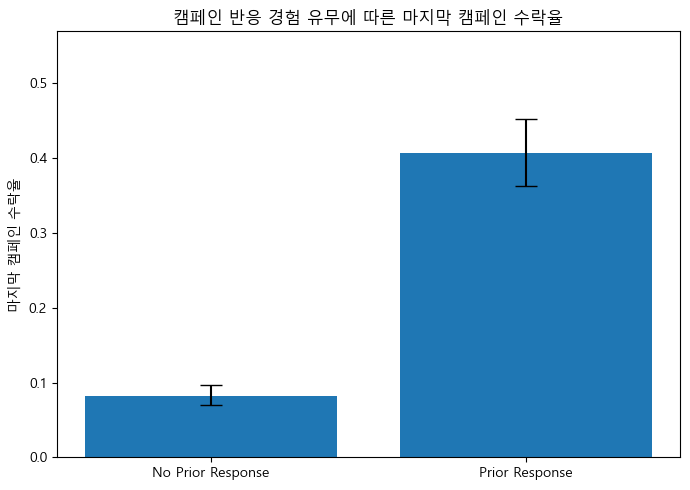

In [70]:
# TODO 5-2(d): 수락률 비교 시각화 (CI 오차막대 포함)

ci_a = wilson_ci(conv_a, n_a)
ci_b = wilson_ci(conv_b, n_b)

rates = [rate_a, rate_b]
lower_errors = [rate_a - ci_a[0], rate_b - ci_b[0]]
upper_errors = [ci_a[1] - rate_a, ci_b[1] - rate_b]

errors = [lower_errors, upper_errors]

groups = ['No Prior Response', 'Prior Response']

plt.figure(figsize=(7,5))

plt.bar(groups, rates, yerr=errors, capsize=8)

plt.ylabel("마지막 캠페인 수락율")
plt.title("캠페인 반응 경험 유무에 따른 마지막 캠페인 수락율")
plt.ylim(0, max(rates)*1.4)

plt.tight_layout()
plt.show()


> ⚠️ **이 분석이 A/B 테스트가 아닌 이유**
>
> A/B 테스트의 본질은 '무작위 배정(Random Assignment)'입니다.
>
> - **A/B 테스트**: 연구자가 참가자를 무작위로 배정 → 인과관계 추론 가능
> - **이 분석**: 고객의 과거 행동으로 그룹이 결정 → 관찰 연구, 인과관계 주장 불가
>
> → 인과관계를 검증하려면 무작위 배정 실험(RCT)을 설계해야 합니다. (문제 5-3)

### 문제 5-3. 진정한 A/B 테스트 설계

새로운 캠페인이 기존 수락률 대비 **2%p** 개선을 가져올 수 있는지 탐지하기 위한
최소 표본 크기를 산정하세요. (α=0.05, Power=0.80)

---
## Challenge: 종합 분석 보고서

지금까지의 분석을 종합하여 FreshCart 마케팅팀에 제출할 보고서를 작성합니다.

### Challenge 1. 고객 그룹별 특성 분석

`Income_Group` × `Has_Children` 6개 조합에 대해 다음을 포함하는 종합 분석표를 작성하세요:

- 고객 수, 평균 소득, 평균/중앙값 소비, 평균 구매 수, 캠페인 반응률, 웹 방문 수
- 그룹 비교 시각화 (1×3 서브플롯: 평균 소비, 반응률, 고객 수)

In [ ]:
# TODO C-1: 고객 그룹별 특성 분석 종합표 + 시각화

### Challenge 2. 비즈니스 제안서

분석 결과를 종합하여 다음을 포함하는 제안서를 작성하세요:

1. **타겟 고객**: 어떤 그룹를 우선 집중 공략해야 하는가? (근거 포함)
2. **채널 전략**: 소득 그룹별 최적 마케팅 채널은?
3. **기대 효과**: 집중 공략 기반 예상 개선 효과
4. **한계점**: 분석의 한계와 추가 필요 데이터

In [ ]:
# TODO C-2: 비즈니스 제안서 작성

---
## 수고하셨습니다!

설날 연휴 따뜻하고 복 가득한 시간 보내요! 💛